In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

E: Failed to fetch http://security.ubuntu.com/ubuntu/pool/universe/o/openjdk-8/openjdk-8-jre-headless_8u312-b07-0ubuntu1~18.04_amd64.deb  404  Not Found [IP: 185.125.190.36 80]
E: Failed to fetch http://security.ubuntu.com/ubuntu/pool/universe/o/openjdk-8/openjdk-8-jdk-headless_8u312-b07-0ubuntu1~18.04_amd64.deb  404  Not Found [IP: 185.125.190.36 80]
E: Unable to fetch some archives, maybe run apt-get update or try with --fix-missing?


In [ ]:
!wget https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop2.7.tgz

--2022-08-09 17:32:51--  https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop2.7.tgz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220272364 (210M) [application/x-gzip]
Saving to: ‘spark-3.0.0-bin-hadoop2.7.tgz’

spark-3.0.0-bin-had 100%[===================>] 210.07M  11.6MB/s    in 22s     

2022-08-09 17:33:13 (9.72 MB/s) - ‘spark-3.0.0-bin-hadoop2.7.tgz’ saved [220272364/220272364]



In [ ]:
!tar -xvzf spark-3.0.0-bin-hadoop2.7.tgz

spark-3.0.0-bin-hadoop2.7/
spark-3.0.0-bin-hadoop2.7/NOTICE
spark-3.0.0-bin-hadoop2.7/kubernetes/
spark-3.0.0-bin-hadoop2.7/kubernetes/tests/
spark-3.0.0-bin-hadoop2.7/kubernetes/tests/worker_memory_check.py
spark-3.0.0-bin-hadoop2.7/kubernetes/tests/py_container_checks.py
spark-3.0.0-bin-hadoop2.7/kubernetes/tests/pyfiles.py
spark-3.0.0-bin-hadoop2.7/kubernetes/dockerfiles/
spark-3.0.0-bin-hadoop2.7/kubernetes/dockerfiles/spark/
spark-3.0.0-bin-hadoop2.7/kubernetes/dockerfiles/spark/entrypoint.sh
spark-3.0.0-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/
spark-3.0.0-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/R/
spark-3.0.0-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/R/Dockerfile
spark-3.0.0-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/python/
spark-3.0.0-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/python/Dockerfile
spark-3.0.0-bin-hadoop2.7/kubernetes/dockerfiles/spark/Dockerfile
spark-3.0.0-bin-hadoop2.7/jars/
spark-3.0.0-bin-hadoop2.7/jars/jacks

In [ ]:
!ls /content/spark-3.0.0-bin-hadoop2.7

bin   data	jars	    LICENSE   NOTICE  R		 RELEASE  yarn
conf  examples	kubernetes  licenses  python  README.md  sbin


In [ ]:
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop2.7"
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("PySpark 3.0 Setup on Google Colab").getOrCreate()
print(spark.sparkContext.appName)

PySpark 3.0 Setup on Google Colab


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import udf, col, when
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
rating = spark.read.csv("/content/drive/MyDrive/ml-latest/ratings.csv", inferSchema = True, header=True)
rating.count()

27753444

In [ ]:
tags = spark.read.csv("/content/drive/MyDrive/ml-latest/tags.csv", inferSchema = True, header=True)
tags.count()

1108997

In [ ]:
links = spark.read.csv("/content/drive/MyDrive/ml-latest/links.csv", inferSchema = True, header=True)
links.count()

58098

In [ ]:
movies = spark.read.csv("/content/drive/MyDrive/ml-latest/movies.csv", inferSchema = True, header=True)
movies.count()

58098

In [ ]:
genome_score = spark.read.csv("/content/drive/MyDrive/ml-latest/genome-scores.csv", inferSchema = True, header=True)
genome_score.count()

14862528

In [ ]:
genome_tags = spark.read.csv("/content/drive/MyDrive/ml-latest/genome-tags.csv", inferSchema = True, header=True)
genome_tags.count()

1128

In [ ]:
data = rating.drop('timestamp')
data.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|    307|   3.5|
|     1|    481|   3.5|
|     1|   1091|   1.5|
|     1|   1257|   4.5|
|     1|   1449|   4.5|
|     1|   1590|   2.5|
|     1|   1591|   1.5|
|     1|   2134|   4.5|
|     1|   2478|   4.0|
|     1|   2840|   3.0|
|     1|   2986|   2.5|
|     1|   3020|   4.0|
|     1|   3424|   4.5|
|     1|   3698|   3.5|
|     1|   3826|   2.0|
|     1|   3893|   3.5|
|     2|    170|   3.5|
|     2|    849|   3.5|
|     2|   1186|   3.5|
|     2|   1235|   3.0|
+------+-------+------+
only showing top 20 rows



In [ ]:
data.describe().show()

+-------+------------------+-----------------+------------------+
|summary|            userId|          movieId|            rating|
+-------+------------------+-----------------+------------------+
|  count|          27753444|         27753444|          27753444|
|   mean|141942.01557064414|18487.99983414671|3.5304452124932677|
| stddev| 81707.40009148984| 35102.6252474677|1.0663527502319696|
|    min|                 1|                1|               0.5|
|    max|            283228|           193886|               5.0|
+-------+------------------+-----------------+------------------+



In [ ]:
!pip install pixiedust

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 197 kB 7.8 MB/s 
  Created wheel for pixiedust: filename=pixiedust-1.1.19-py3-none-any.whl size=321805 sha256=c5c0b9a6f4168aa0029a293dacbb8662b92493f31612e9a095b931329f78df97
  Stored in directory: /root/.cache/pip/wheels/05/07/e7/8aca0e820027a63157a916424fd748fb2a2a3e71de5e08eeb8
Successfully built pixiedust


In [ ]:
import pixiedust
display(rating)

Pixiedust database opened successfully
Table VERSION_TRACKER created successfully
Table METRICS_TRACKER created successfully

Share anonymous install statistics? (opt-out instructions)

PixieDust will record metadata on its environment the next time the package is installed or updated. The data is anonymized and aggregated to help plan for future releases, and records only the following values:

{
   "data_sent": currentDate,
   "runtime": "python",
   "application_version": currentPixiedustVersion,
   "space_id": nonIdentifyingUniqueId,
   "config": {
       "repository_id": "https://github.com/ibm-watson-data-lab/pixiedust",
       "target_runtimes": ["Data Science Experience"],
       "event_id": "web",
       "event_organizer": "dev-journeys"
   }
}
You can opt out by calling pixiedust.optOut() in a new cell.


Pixiedust runtime updated. Please restart kernel
Table SPARK_PACKAGES created successfully
Table USER_PREFERENCES created successfully
Table service_connections created successfully


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pixiedust
display(rating)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
rate = pd.read_csv("/content/drive/MyDrive/ml-latest/ratings.csv")
movie = pd.read_csv("/content/drive/MyDrive/ml-latest/movies.csv")
genome_sc = pd.read_csv("/content/drive/MyDrive/ml-latest/genome-scores.csv")
tag = pd.read_csv("/content/drive/MyDrive/ml-latest/tags.csv")
link = pd.read_csv("/content/drive/MyDrive/ml-latest/links.csv")
genome_tg = pd.read_csv("/content/drive/MyDrive/ml-latest/genome-tags.csv")

In [ ]:
genome_sc

,movieId,tagId,relevance
0,1,1,0.02900
1,1,2,0.02375
2,1,3,0.05425
3,1,4,0.06875
4,1,5,0.16000
...,...,...,...
14862523,187595,1124,0.10700
14862524,187595,1125,0.05850
14862525,187595,1126,0.03800
14862526,187595,1127,0.10225


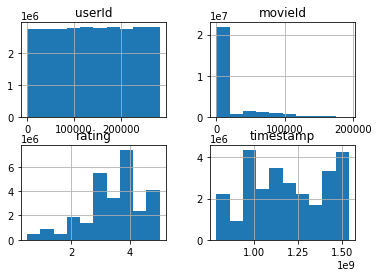

In [ ]:
rate.hist()
plt.show()

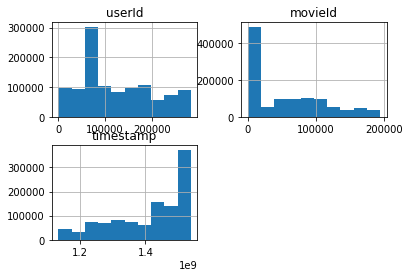

In [ ]:
tag.hist()
plt.show()

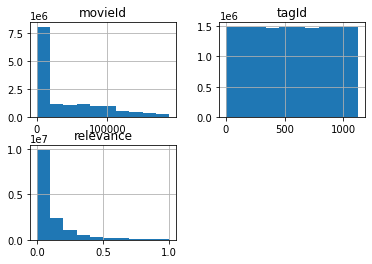

In [ ]:
genome_sc.hist()
plt.show()

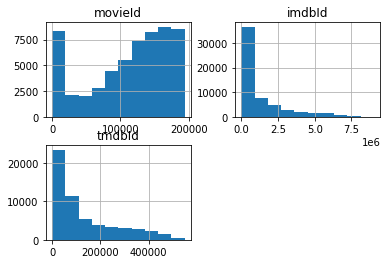

In [ ]:
link.hist()
plt.show()

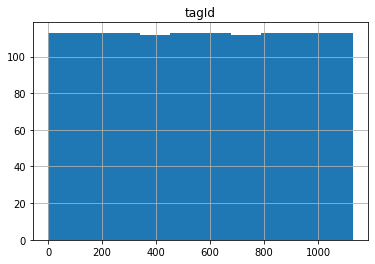

In [ ]:
genome_tg.hist()
plt.show()

In [ ]:
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", nonnegative = True)

In [ ]:
(train, test) = data.randomSplit([0.7,0.3], seed = 1234)

In [ ]:
eval = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

In [ ]:
# Param_Grid
param_grid = ParamGridBuilder()\
             .addGrid(als.rank, [2,5,10])\
             .addGrid(als.maxIter,[5,10,15])\
             .addGrid(als.regParam,[0.17,0.18,0.19])\
             .build()

In [ ]:
# Cross validation
cv = CrossValidator(estimator=als,
                            estimatorParamMaps=param_grid,
                            evaluator=eval,
                            numFolds=3)

In [ ]:
model1 = cv.fit(train)

In [ ]:
# Fitting Alternative Least Square (ALS) in recommender system
model = als.fit(train)

In [ ]:
pred = model.transform(test)

In [ ]:
pred.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|107339|    148|   4.0|  3.695717|
| 93112|    148|   3.0| 3.3270206|
|253535|    148|   4.0|  2.502245|
| 65991|    148|   4.0|  2.780499|
|244192|    148|   3.0| 2.3309245|
|273242|    148|   4.0| 3.6454456|
| 98426|    148|   3.0| 2.5258708|
|108082|    148|   3.0| 2.8827784|
|275860|    148|   3.0| 2.7257156|
|211963|    148|   3.0| 2.0727887|
|255236|    148|   2.0| 2.8417406|
| 30292|    148|   4.0| 3.1444325|
|236566|    148|   4.0|  3.273036|
| 73492|    148|   0.5| 1.8978112|
| 93731|    148|   3.0| 2.7677135|
|  8264|    148|   1.0|  2.174167|
|282489|    148|   4.0| 3.3463602|
| 76830|    148|   2.0| 2.5952723|
| 84032|    148|   3.0|0.79624516|
|146098|    148|   2.0| 2.3770823|
+------+-------+------+----------+
only showing top 20 rows



In [ ]:
rmse = eval.evaluate(pred)
print(f"RMSE:{rmse}")

RMSE:0.8431590740583425


In [ ]:
user_1 = test.filter(test['userId']==1).select(['movieId', 'userId'])

In [ ]:
user_1.show()

+-------+------+
|movieId|userId|
+-------+------+
|    307|     1|
|    481|     1|
|   1449|     1|
+-------+------+



In [ ]:
rec = model.transform(user_1)

In [ ]:
rec.orderBy("prediction", ascending = False).show()

+-------+------+----------+
|movieId|userId|prediction|
+-------+------+----------+
|   1449|     1| 4.3610682|
|    481|     1| 3.6897821|
|    307|     1|  3.574817|
+-------+------+----------+



In [ ]:
iter = 10
reg_param = 0.1
rank = 4
als = ALS(maxIter=iter, regParam=reg_param, rank = rank, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", nonnegative = True)

In [ ]:
model1 = als.fit(train)

In [ ]:
predictions = model1.transform(test)
new_pred = predictions.filter(col('prediction') !=np.nan)

In [ ]:
evaluator = RegressionEvaluator(metricName = "rmse", labelCol = "rating", predictionCol = "prediction")
rmse = evaluator.evaluate(new_pred)
print("RMSE: " + str(rmse))

RMSE: 0.8352296316365788


In [ ]:
predictions.show(n=10)

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|107339|    148|   4.0| 3.3397624|
| 93112|    148|   3.0| 2.9233184|
|253535|    148|   4.0| 3.1292667|
| 65991|    148|   4.0|  3.010223|
|244192|    148|   3.0| 2.6334314|
|273242|    148|   4.0| 3.4192019|
| 98426|    148|   3.0| 2.4092486|
|108082|    148|   3.0| 2.7876494|
|275860|    148|   3.0| 2.7570927|
|211963|    148|   3.0| 2.3223023|
+------+-------+------+----------+
only showing top 10 rows



In [ ]:
predictions.join(movies, "movieId").select("userId","title","genres","rating","prediction").show(5)

+------+--------------------+------+------+----------+
|userId|               title|genres|rating|prediction|
+------+--------------------+------+------+----------+
|107339|Awfully Big Adven...| Drama|   4.0| 3.3397624|
| 93112|Awfully Big Adven...| Drama|   3.0| 2.9233184|
|253535|Awfully Big Adven...| Drama|   4.0| 3.1292667|
| 65991|Awfully Big Adven...| Drama|   4.0|  3.010223|
|244192|Awfully Big Adven...| Drama|   3.0| 2.6334314|
+------+--------------------+------+------+----------+
only showing top 5 rows



In [ ]:
A_user = predictions.filter(col("userId")==10).join(movies,"movieId").join(links,"movieId").select("userId","title",
          "genres","imdbId", "prediction", "rating")
A_user.show(5)

+------+--------------------+--------------------+------+----------+------+
|userId|               title|              genres|imdbId|prediction|rating|
+------+--------------------+--------------------+------+----------+------+
|    10|      Aladdin (1992)|Adventure|Animati...|103639|   3.69902|   4.0|
|    10|When Harry Met Sa...|      Comedy|Romance| 98635| 3.9904413|   3.0|
|    10|   Doors, The (1991)|               Drama|101761| 3.4515612|   2.0|
|    10|All About My Moth...|               Drama|185125| 4.2808385|   5.0|
|    10|  Taxi Driver (1976)|Crime|Drama|Thriller| 75314|  4.382608|   4.0|
+------+--------------------+--------------------+------+----------+------+
only showing top 5 rows



In [ ]:
MovieRecommend = model.recommendForAllItems(5)

In [ ]:
MovieRecommend.show(5)

+-------+--------------------+
|movieId|     recommendations|
+-------+--------------------+
|    148|[[270973, 8.37996...|
|    463|[[261538, 7.12717...|
|    471|[[110091, 6.63943...|
|    496|[[270973, 12.2585...|
|    833|[[10878, 5.918998...|
+-------+--------------------+
only showing top 5 rows



In [ ]:
movie_ids = [1582, 3175,2545, 1245]
user_ids = [543,543,543, 543]
new_user_pred = spark.createDataFrame(zip(movie_ids, user_ids), schema = ['movieId', "userId"])

In [ ]:
new_predict = model1.transform(new_user_pred)
new_predict.show()

+-------+------+----------+
|movieId|userId|prediction|
+-------+------+----------+
|   3175|   543| 3.4556303|
|   1582|   543| 2.5615046|
|   1245|   543| 3.8023696|
|   2545|   543|  2.911374|
+-------+------+----------+



In [ ]:
iter = 15
reg_param = 0.2
rank = 3
als = ALS(maxIter=iter, regParam=reg_param, rank = rank, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", nonnegative = True)

In [ ]:
model2 = als.fit(train)

In [ ]:
predictions = model2.transform(test)
new_pred = predictions.filter(col('prediction') !=np.nan)

In [ ]:
evaluator = RegressionEvaluator(metricName = "rmse", labelCol = "rating", predictionCol = "prediction")
rmse = evaluator.evaluate(new_pred)
print("RMSE: " + str(rmse))

RMSE: 0.8697660500905325


In [ ]:
predictions.join(movies, "movieId").select("userId","title","genres","rating","prediction").show(5)

+------+--------------------+------+------+----------+
|userId|               title|genres|rating|prediction|
+------+--------------------+------+------+----------+
|107339|Awfully Big Adven...| Drama|   4.0| 3.1624172|
| 93112|Awfully Big Adven...| Drama|   3.0| 2.7276938|
|253535|Awfully Big Adven...| Drama|   4.0| 2.9951508|
| 65991|Awfully Big Adven...| Drama|   4.0| 2.8531837|
|244192|Awfully Big Adven...| Drama|   3.0| 2.3730445|
+------+--------------------+------+------+----------+
only showing top 5 rows

